In [15]:
!pip install --quiet torch torchvision pandas matplotlib numpy scikit-learn tqdm

import os
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Installing required packages...


In [16]:
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS_FROZEN = 10  # Epochs for frozen backbone training
NUM_EPOCHS_FINETUNE = 5  # Epochs for fine-tuning
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


In [17]:
print("\n=== Preparing Data ===")

# Check if running in Colab and need to unzip, anyone else can change this as per them
if os.path.exists('/content'):
    print("Detected Colab environment - checking for zip files...")
    if os.path.exists('train.zip'):
        print("Unzipping train.zip...")
        !unzip -q train.zip
    if os.path.exists('test.zip'):
        print("Unzipping test.zip...")
        !unzip -q test.zip

    print("Files in working directory:", os.listdir("/content")[:20])
    if os.path.exists("/content/train"):
        print("Train folder sample:", os.listdir("/content/train")[:5])
    if os.path.exists("/content/test"):
        print("Test folder sample:", os.listdir("/content/test")[:5])

    # Set data directory for Colab
    DATA_DIR = '/content'
    train_csv_path = "/content/train.csv"
    test_csv_path = "/content/test.csv"
else:
    # Local environment
    DATA_DIR = 'data'
    train_csv_path = "data/train.csv"
    test_csv_path = "data/test.csv"

# Load CSV files
print(f"\nLoading CSV files from {DATA_DIR}...")
full_dataset = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print("\nTrain CSV head:")
print(full_dataset.head())
print(f"\nTrain dataset shape: {full_dataset.shape}")

print("\nTest CSV head:")
print(test_df.head())
print(f"Test dataset shape: {test_df.shape}")

# Determine number of classes
num_classes = full_dataset["label"].nunique()
print(f"\n✓ Number of classes: {num_classes}")

# Check class distribution
print("\nClass distribution in training set:")
class_counts = full_dataset['label'].value_counts().sort_index()
print(f"Min samples per class: {class_counts.min()}")
print(f"Max samples per class: {class_counts.max()}")
print(f"Mean samples per class: {class_counts.mean():.2f}")


=== Preparing Data ===
Detected Colab environment - checking for zip files...
Unzipping train.zip...
Unzipping test.zip...
Files in working directory: ['.config', 'train', 'test', 'train.csv', 'test.zip', 'train.zip', 'test.csv', 'sample_data']
Train folder sample: ['2066.jpg', '2713.jpg', '3924.jpg', '1955.jpg', '4070.jpg']
Test folder sample: ['5999.jpg', '5917.jpg', '4515.jpg', '4557.jpg', '4611.jpg']

Loading CSV files from /content...

Train CSV head:
            id  label
0  train/1.jpg      3
1  train/2.jpg     80
2  train/3.jpg     95
3  train/4.jpg     78
4  train/5.jpg     85

Train dataset shape: (4135, 2)

Test CSV head:
              id
0  test/4136.jpg
1  test/4137.jpg
2  test/4138.jpg
3  test/4139.jpg
4  test/4140.jpg
Test dataset shape: (4080, 1)

✓ Number of classes: 100

Class distribution in training set:
Min samples per class: 28
Max samples per class: 49
Mean samples per class: 41.35


In [18]:
class CarDataset(Dataset): #changed it a bit
    """
    Custom Dataset class for car images
    Handles both training data (with labels) and test data (without labels)
    """
    def __init__(self, df, data_dir='.', transform=None):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row["id"]  # e.g., "train/1.jpg" or "test/4136.jpg"

        # Construct full path
        img_path = os.path.join(self.data_dir, img_id)

        # Load label if it exists (train.csv has 'label', test.csv doesn't)
        label = int(row["label"]) if "label" in row else -1

        # Load and convert image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [19]:
print("\n" + "="*80)
print("TECHNIQUE 1: Enhanced Data Augmentation")
print("="*80)

# Heavy augmentation for training (prevents overfitting)
train_transform_heavy = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2))  # Cutout augmentation
])

# No augmentation for validation and test
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

print("✓ Augmentation strategies defined:")
print("  - Training: Flip, Rotation(±15°), ColorJitter, Affine, Perspective, RandomErasing")
print("  - Validation/Test: No augmentation (clean images)")


TECHNIQUE 1: Enhanced Data Augmentation
✓ Augmentation strategies defined:
  - Training: Flip, Rotation(±15°), ColorJitter, Affine, Perspective, RandomErasing
  - Validation/Test: No augmentation (clean images)


In [20]:
print("\n" + "="*80)
print("TECHNIQUE 2 & 3: Transfer Learning with Progressive Fine-tuning")
print("="*80)

def create_resnet50_model(num_classes, freeze_layers=True):
    """
    Create ResNet50 model for transfer learning

    Args:
        num_classes: Number of output classes
        freeze_layers: If True, freeze all layers except classifier

    Returns:
        model: ResNet50 model ready for training
    """
    print("\nCreating ResNet50 model...")
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # Replace final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    if freeze_layers:
        # Freeze all layers
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze only the classifier
        for param in model.fc.parameters():
            param.requires_grad = True

        print(" Model created with frozen backbone")
        print(f"  - Trainable params: Classifier only ({num_features} -> {num_classes})")
    else:
        print(" Model created with all layers trainable")

    return model

def unfreeze_last_layers(model):
    """
    Unfreeze layer3 and layer4 of ResNet50 for fine-tuning

    Args:
        model: ResNet50 model

    Returns:
        model: Model with unfrozen layers
    """
    print("\nUnfreezing last layers for fine-tuning...")

    # Unfreeze layer4 (last residual block)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Unfreeze layer3 (second-to-last residual block)
    for param in model.layer3.parameters():
        param.requires_grad = True

    print("✓ Unfroze layer3 and layer4 (last two residual blocks)")

    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"  - Trainable params: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.1f}%)")

    return model


TECHNIQUE 2 & 3: Transfer Learning with Progressive Fine-tuning


In [21]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{correct/total:.4f}"
        })

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [22]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler, num_epochs, device, save_path='best_model.pt', title='Model'):
    """
    Complete training pipeline with validation and checkpointing

    Returns:
        History of training: losses and accuracies
    """
    best_val_acc = 0.0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    print(f"\nStarting training for: {title}")
    print("="*60)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)


        # Learning rate scheduling
        if scheduler:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != old_lr:
                print(f'Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}')

    print(f"\n{'='*60}")
    print(f"Training complete for {title}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    print(f"{'='*60}\n")

    return train_losses, train_accs, val_losses, val_accs

In [23]:
def plot_training_history(train_losses, train_accs, val_losses, val_accs, title=''):
    """Plot training and validation metrics"""
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2, marker='o')
    ax1.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2, marker='s')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{title} - Loss Curves', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, train_accs, 'b-', label='Train Acc', linewidth=2, marker='o')
    ax2.plot(epochs, val_accs, 'r-', label='Val Acc', linewidth=2, marker='s')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title(f'{title} - Accuracy Curves', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_")}_history.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print final statistics
    print(f"\n{title} - Final Statistics:")
    print(f"  Final Train Loss: {train_losses[-1]:.4f} | Final Train Acc: {train_accs[-1]:.4f}")
    print(f"  Final Val Loss:   {val_losses[-1]:.4f} | Final Val Acc:   {val_accs[-1]:.4f}")
    print(f"  Best Val Acc:     {max(val_accs):.4f} (Epoch {val_accs.index(max(val_accs))+1})")
    print(f"  Overfitting Gap:  {(train_accs[-1] - val_accs[-1]):.4f}")

def plot_comparison(history1, history2):
    """Plot comparison between frozen and fine-tuned models"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Validation loss comparison
    ax1.plot(range(1, len(history1[2])+1), history1[2], 'b-', label='Stage 1: Frozen', linewidth=2, marker='o')
    ax1.plot(range(1, len(history2[2])+1), history2[2], 'r-', label='Stage 2: Fine-tuned', linewidth=2, marker='s')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Validation Loss', fontsize=12)
    ax1.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Validation accuracy comparison
    ax2.plot(range(1, len(history1[3])+1), history1[3], 'b-', label='Stage 1: Frozen', linewidth=2, marker='o')
    ax2.plot(range(1, len(history2[3])+1), history2[3], 'r-', label='Stage 2: Fine-tuned', linewidth=2, marker='s')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Validation Accuracy', fontsize=12)
    ax2.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('stage_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nComparison Summary:")
    print(f"  Stage 1 Best Val Acc: {max(history1[3]):.4f}")
    print(f"  Stage 2 Best Val Acc: {max(history2[3]):.4f}")
    print(f"  Improvement: {(max(history2[3]) - max(history1[3])):.4f} ({100*(max(history2[3]) - max(history1[3])):.2f}%)")

In [24]:
print("\n" + "="*80)
print("Creating Train/Validation Split and DataLoaders")
print("="*80)

# Split with stratification to maintain class balance
train_df, val_df = train_test_split(
    full_dataset,
    test_size=0.2,
    random_state=42,
    stratify=full_dataset['label']
)

print(f"\nDataset sizes:")
print(f"  Training:   {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test:       {len(test_df):,} samples")

# Create datasets with heavy augmentation for training
train_dataset = CarDataset(train_df, data_dir=DATA_DIR, transform=train_transform_heavy)
val_dataset = CarDataset(val_df, data_dir=DATA_DIR, transform=val_transform)

# Create dataloaders
num_workers = 2 if DEVICE.type == 'cuda' else 0
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=num_workers, pin_memory=True)

print(f"\n DataLoaders created:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")


Creating Train/Validation Split and DataLoaders

Dataset sizes:
  Training:   3,308 samples
  Validation: 827 samples
  Test:       4,080 samples

✓ DataLoaders created:
  Batch size: 32
  Train batches: 104
  Val batches: 26



STAGE 1: Training with Frozen Backbone

Creating ResNet50 model...
✓ Model created with frozen backbone
  - Trainable params: Classifier only (2048 -> 100)

Starting training for: ResNet50 Stage 1 (Frozen)

Epoch 1/10
--------------------------------------------------


Train Loss: 4.4090 | Train Acc: 0.0559
Val Loss:   3.9593 | Val Acc:   0.1258
✓ Model saved! New best validation accuracy: 0.1258

Epoch 2/10
--------------------------------------------------


Train Loss: 3.7739 | Train Acc: 0.1880
Val Loss:   3.6232 | Val Acc:   0.2152
✓ Model saved! New best validation accuracy: 0.2152

Epoch 3/10
--------------------------------------------------


Train Loss: 3.3898 | Train Acc: 0.2681
Val Loss:   3.3878 | Val Acc:   0.2370
✓ Model saved! New best validation accuracy: 0.2370

Epoch 4/10
--------------------------------------------------


Train Loss: 3.1072 | Train Acc: 0.3322
Val Loss:   3.1502 | Val Acc:   0.2709
✓ Model saved! New best validation accuracy: 0.2709

Epoch 5/10
--------------------------------------------------


Train Loss: 2.8755 | Train Acc: 0.3909
Val Loss:   3.0409 | Val Acc:   0.2963
✓ Model saved! New best validation accuracy: 0.2963

Epoch 6/10
--------------------------------------------------


Train Loss: 2.6543 | Train Acc: 0.4480
Val Loss:   2.9025 | Val Acc:   0.3313
✓ Model saved! New best validation accuracy: 0.3313

Epoch 7/10
--------------------------------------------------


Train Loss: 2.5118 | Train Acc: 0.4719
Val Loss:   2.8199 | Val Acc:   0.3301

Epoch 8/10
--------------------------------------------------


Train Loss: 2.3762 | Train Acc: 0.4976
Val Loss:   2.7668 | Val Acc:   0.3386
✓ Model saved! New best validation accuracy: 0.3386

Epoch 9/10
--------------------------------------------------


Train Loss: 2.2374 | Train Acc: 0.5281
Val Loss:   2.6739 | Val Acc:   0.3482
✓ Model saved! New best validation accuracy: 0.3482

Epoch 10/10
--------------------------------------------------


Train Loss: 2.1330 | Train Acc: 0.5475
Val Loss:   2.6329 | Val Acc:   0.3555
✓ Model saved! New best validation accuracy: 0.3555

Training complete for ResNet50 Stage 1 (Frozen)
Best validation accuracy: 0.3555



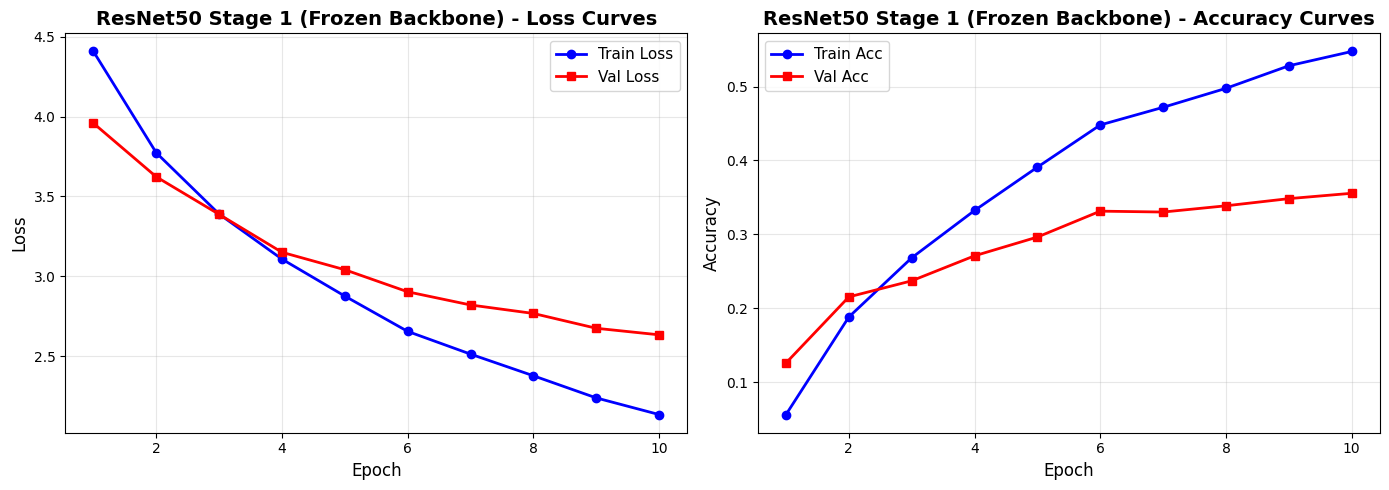


ResNet50 Stage 1 (Frozen Backbone) - Final Statistics:
  Final Train Loss: 2.1330 | Final Train Acc: 0.5475
  Final Val Loss:   2.6329 | Final Val Acc:   0.3555
  Best Val Acc:     0.3555 (Epoch 10)
  Overfitting Gap:  0.1920


In [25]:
print("\n" + "="*80)
print("STAGE 1: Training with Frozen Backbone")
print("="*80)

model = create_resnet50_model(num_classes=num_classes, freeze_layers=True).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

history_frozen = train_model(
    model, train_loader, val_loader, criterion, optimizer,
    scheduler, num_epochs=NUM_EPOCHS_FROZEN, device=DEVICE,
    save_path='resnet50_frozen.pt', title='ResNet50 Stage 1 (Frozen)'
)

plot_training_history(*history_frozen, title='ResNet50 Stage 1 (Frozen Backbone)')


STAGE 2: Fine-tuning with Unfrozen Layer3 and Layer4

Creating ResNet50 model...
✓ Model created with frozen backbone
  - Trainable params: Classifier only (2048 -> 100)

Unfreezing last layers for fine-tuning...
✓ Unfroze layer3 and layer4 (last two residual blocks)
  - Trainable params: 22,268,004 / 23,712,932 (93.9%)

Starting training for: ResNet50 Stage 2 (Fine-tuned)

Epoch 1/5
--------------------------------------------------


Train Loss: 1.2633 | Train Acc: 0.6774
Val Loss:   1.6540 | Val Acc:   0.5345
✓ Model saved! New best validation accuracy: 0.5345

Epoch 2/5
--------------------------------------------------


Train Loss: 0.6991 | Train Acc: 0.8156
Val Loss:   1.3543 | Val Acc:   0.6034
✓ Model saved! New best validation accuracy: 0.6034

Epoch 3/5
--------------------------------------------------


Train Loss: 0.4664 | Train Acc: 0.8782
Val Loss:   1.2990 | Val Acc:   0.6288
✓ Model saved! New best validation accuracy: 0.6288

Epoch 4/5
--------------------------------------------------


Train Loss: 0.3208 | Train Acc: 0.9250
Val Loss:   1.2301 | Val Acc:   0.6723
✓ Model saved! New best validation accuracy: 0.6723

Epoch 5/5
--------------------------------------------------


Train Loss: 0.2355 | Train Acc: 0.9450
Val Loss:   1.1504 | Val Acc:   0.6880
✓ Model saved! New best validation accuracy: 0.6880

Training complete for ResNet50 Stage 2 (Fine-tuned)
Best validation accuracy: 0.6880



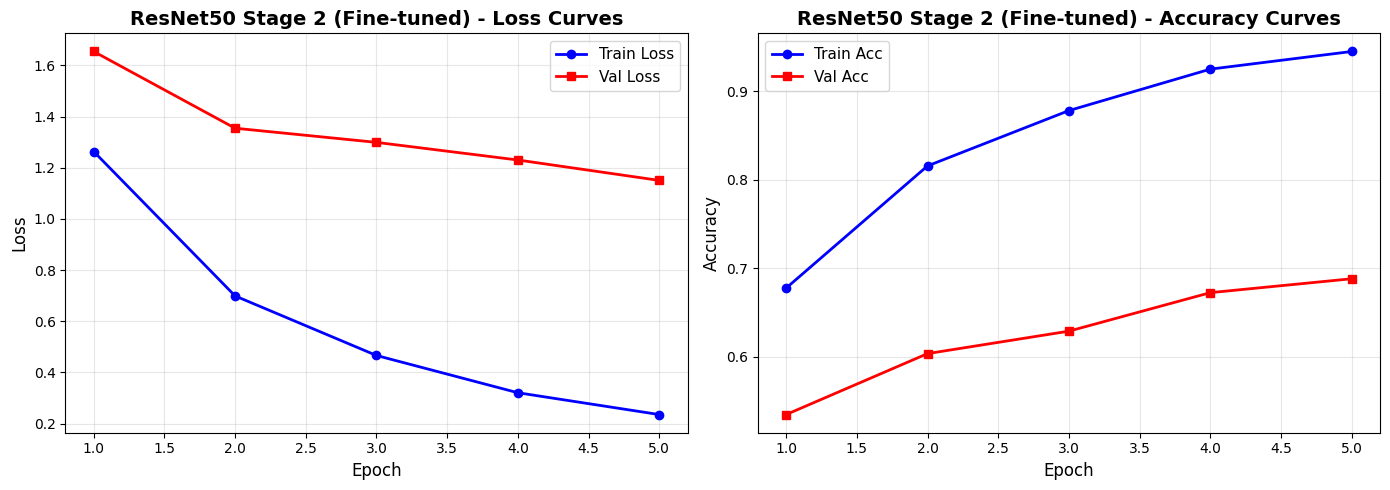


ResNet50 Stage 2 (Fine-tuned) - Final Statistics:
  Final Train Loss: 0.2355 | Final Train Acc: 0.9450
  Final Val Loss:   1.1504 | Final Val Acc:   0.6880
  Best Val Acc:     0.6880 (Epoch 5)
  Overfitting Gap:  0.2570


In [30]:
print("\n" + "="*80)
print("STAGE 2: Fine-tuning with Unfrozen Layer3 and Layer4")
print("="*80)

# Load the best model from Stage 1
model = create_resnet50_model(num_classes=num_classes, freeze_layers=True).to(DEVICE)
model.load_state_dict(torch.load('resnet50_frozen.pt', map_location=DEVICE))

# Unfreeze layer3 and layer4
model = unfreeze_last_layers(model)

# Use lower learning rate for fine-tuning
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', patience=2, factor=0.5)

history_finetuned = train_model(
    model, train_loader, val_loader, criterion, optimizer_ft,
    scheduler_ft, num_epochs=NUM_EPOCHS_FINETUNE, device=DEVICE,
    save_path='resnet50_finetuned.pt', title='ResNet50 Stage 2 (Fine-tuned)'
)

plot_training_history(*history_finetuned, title='ResNet50 Stage 2 (Fine-tuned)')


STAGE COMPARISON


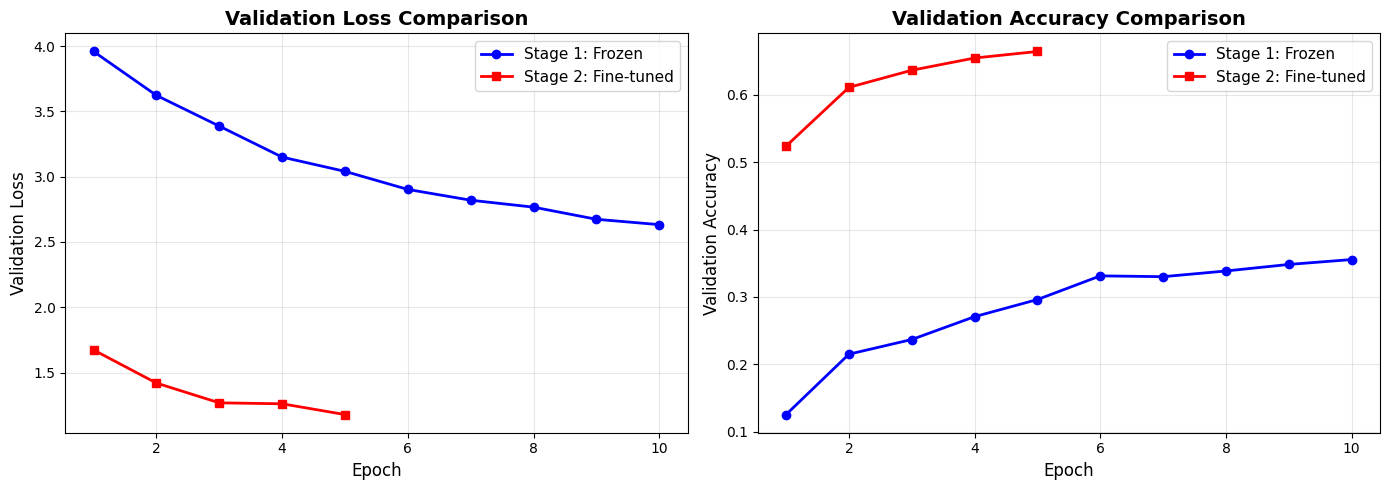


Comparison Summary:
  Stage 1 Best Val Acc: 0.3555
  Stage 2 Best Val Acc: 0.6638
  Improvement: 0.3083 (30.83%)


In [28]:
print("\n" + "="*80)
print("STAGE COMPARISON")
print("="*80)

plot_comparison(history_frozen, history_finetuned)

In [29]:
print("\n" + "="*80)
print("TRAINING COMPLETE - FINAL SUMMARY")
print("="*80)

print("\nSaved model files:")
print("  1. resnet50_frozen.pt       - After Stage 1 (frozen backbone)")
print("  2. resnet50_finetuned.pt    - After Stage 2 (fine-tuned) ← BEST MODEL")

print("\nPerformance Summary:")
print(f"  Stage 1 (Frozen):    Best Val Acc = {max(history_frozen[3]):.4f}")
print(f"  Stage 2 (Fine-tuned): Best Val Acc = {max(history_finetuned[3]):.4f}")
print(f"  Total Improvement:   +{(max(history_finetuned[3]) - max(history_frozen[3])):.4f} ({100*(max(history_finetuned[3]) - max(history_frozen[3])):.2f}%)")

print("\n" + "="*80)
print("TECHNIQUES IMPLEMENTED:")
print("="*80)
print(" Technique 1: Enhanced Data Augmentation")
print("  - Heavy augmentation with 8+ transformations")
print("  - RandomHorizontalFlip, RandomRotation(±15°)")
print("  - ColorJitter (brightness, contrast, saturation, hue)")
print("  - RandomAffine, RandomPerspective")
print("  - RandomErasing (cutout)")
print("")
print(" Technique 2: Transfer Learning")
print("  - Pre-trained ResNet50 from ImageNet")
print("  - Replaced final FC layer for 100 classes")
print("  - Frozen backbone, trained classifier only")
print("")
print(" Technique 3: Progressive Fine-tuning")
print("  - Stage 1: Train classifier with frozen backbone (10 epochs)")
print("  - Stage 2: Unfreeze layer3 + layer4 and fine-tune (5 epochs)")
print("  - Lower learning rate (1e-4) for fine-tuning")
print("  - Learning rate scheduling with ReduceLROnPlateau")

print("\n✓ Ready to generate predictions for Kaggle submission!")


TRAINING COMPLETE - FINAL SUMMARY

Saved model files:
  1. resnet50_frozen.pt       - After Stage 1 (frozen backbone)
  2. resnet50_finetuned.pt    - After Stage 2 (fine-tuned) ← BEST MODEL

Performance Summary:
  Stage 1 (Frozen):    Best Val Acc = 0.3555
  Stage 2 (Fine-tuned): Best Val Acc = 0.6638
  Total Improvement:   +0.3083 (30.83%)

TECHNIQUES IMPLEMENTED:
✓ Technique 1: Enhanced Data Augmentation
  - Heavy augmentation with 8+ transformations
  - RandomHorizontalFlip, RandomRotation(±15°)
  - ColorJitter (brightness, contrast, saturation, hue)
  - RandomAffine, RandomPerspective
  - RandomErasing (cutout)

✓ Technique 2: Transfer Learning
  - Pre-trained ResNet50 from ImageNet
  - Replaced final FC layer for 100 classes
  - Frozen backbone, trained classifier only

✓ Technique 3: Progressive Fine-tuning
  - Stage 1: Train classifier with frozen backbone (10 epochs)
  - Stage 2: Unfreeze layer3 + layer4 and fine-tune (5 epochs)
  - Lower learning rate (1e-4) for fine-tuning
 